In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import r2_score

In [140]:
np.random.seed(3888)
tf.random.set_seed(3888)

In [141]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_120.csv")

In [142]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)

    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
        .transform(lambda x: np.sqrt(
            ((x.shift(1) ** 2)
                .rolling(30, min_periods=1)
                .sum()
            ).clip(lower=0)
        ))
    )

    # TARGET
    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-30)   
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df = df.dropna()   
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [143]:
df = make_features(df)

In [144]:
def add_time_features(df_enriched: pd.DataFrame, period: int = 600):

    theta = 2 * np.pi * df_enriched['seconds_in_bucket'] / period
    df_enriched['sec_sin'] = np.sin(theta)
    df_enriched['sec_cos'] = np.cos(theta)

    return df_enriched.drop(columns=["seconds_in_bucket"])

df = add_time_features(df)

In [145]:
for c in ['bid_size1','ask_size1','bid_size2','ask_size2']:
    df[c + '_log'] = np.log1p(df[c])
    df.drop(columns=c, inplace=True)

In [146]:
feature_cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',
       'mid_price', 'spread', 'imbalance', 'book_pressure',
       'microprice', 'normalized_spread', 'OBI_L2', 'LOB_entropy',
       'LOB_entropy_normalized', 'log_return', 'realized_volatility', 'bipower_var', 'wap', 'log_wap_return', 'imbalance_lag1',
       'imbalance_lag2', 'book_pressure_lag1', 'book_pressure_lag2',
       'log_return_lag1', 'log_return_lag2', 'rolling_vol_30',
       'rolling_imbalance_mean_30', 'sec_sin', 'sec_cos', 'bid_size1_log',
       'ask_size1_log', 'bid_size2_log', 'ask_size2_log']
target_col = "rv_future"

In [147]:
df['rv_future_log'] = np.log1p(df['rv_future'])
feature_cols_mod = [c for c in feature_cols if c!='rv_future'] 
target_col_mod     = 'rv_future_log'

In [148]:
unique_sessions = df["time_id"].sort_values().unique()
split_idx       = int(len(unique_sessions) * 0.8)          
train_sessions  = unique_sessions[:split_idx]
test_sessions   = unique_sessions[split_idx:]

In [149]:
train_df = df[df["time_id"].isin(train_sessions)].copy()
test_df  = df[df["time_id"].isin(test_sessions)].copy()

In [150]:
x_scaler = MinMaxScaler().fit(train_df[feature_cols_mod])
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(train_df[[target_col_mod]])

train_df[feature_cols_mod] = x_scaler.transform(train_df[feature_cols_mod])
test_df[feature_cols_mod]  = x_scaler.transform(test_df[feature_cols_mod])
train_df[target_col_mod]   = y_scaler.transform(train_df[[target_col_mod]])
test_df[target_col_mod]    = y_scaler.transform(test_df[[target_col_mod]])

In [151]:
SEQ_LEN = 30   

def build_sequences(df_part: pd.DataFrame, feature_cols, target_col, seq_len):
    """Return X, y arrays where each sample is wholly inside one session."""
    X, y = [], []
    for _, session in df_part.groupby("time_id"):
        data   = session[feature_cols].values
        target = session[target_col].values
        for i in range(len(session) - seq_len):
            X.append(data[i : i + seq_len])
            y.append(target[i + seq_len])
    return np.asarray(X), np.asarray(y)

X_train, y_train = build_sequences(train_df, feature_cols, target_col, SEQ_LEN)
X_test,  y_test  = build_sequences(test_df,  feature_cols, target_col, SEQ_LEN)

In [152]:
def build_transformer_model(seq_len, num_features,
                            d_model=64, num_heads=4, num_layers=2):
    inputs = layers.Input(shape=(seq_len, num_features))

    # Linear projection to d_model
    x = layers.Dense(d_model)(inputs)

    # Stacked Transformer encoder blocks
    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model)(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        ffn_out = layers.Dense(d_model * 4, activation="relu")(x)
        ffn_out = layers.Dense(d_model)(ffn_out)
        x       = layers.Add()([x, ffn_out])
        x       = layers.LayerNormalization(epsilon=1e-6)(x)

    x      = layers.GlobalAveragePooling1D()(x)   # time pooling
    output = layers.Dense(1)(x)
    return models.Model(inputs, output)

model = build_transformer_model(SEQ_LEN, len(feature_cols))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

In [153]:
val_split_idx = int(len(train_sessions) * 0.9)
val_sessions  = train_sessions[val_split_idx:]
train_sessions= train_sessions[:val_split_idx]

val_df = train_df[train_df["time_id"].isin(val_sessions)]
train_df = train_df[train_df["time_id"].isin(train_sessions)]

X_train, y_train = build_sequences(train_df, feature_cols_mod, 'rv_future_log', SEQ_LEN)
X_val,   y_val   = build_sequences(val_df,   feature_cols_mod, 'rv_future_log', SEQ_LEN)
X_test,  y_test  = build_sequences(test_df,  feature_cols_mod, 'rv_future_log', SEQ_LEN)

In [154]:
num_feats = X_train.shape[2]  
model = build_transformer_model(SEQ_LEN, num_feats)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse"
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2,
    batch_size=32,
    callbacks=[callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True
    )],
    verbose=1,
)

Epoch 1/2
38005/38005 ━━━━━━━━━━━━━━━━━━━━ 668s 18ms/step - loss: 0.0076 - val_loss: 1.2129e-04
Epoch 2/2
38005/38005 ━━━━━━━━━━━━━━━━━━━━ 661s 17ms/step - loss: 1.4785e-04 - val_loss: 1.1976e-04


In [155]:
pred_scaled = model.predict(X_test, verbose=1).flatten()
actual_scaled = y_test.flatten()

predictions = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actuals     = y_scaler.inverse_transform(actual_scaled.reshape(-1, 1)).flatten()

mse   = np.mean((predictions - actuals) ** 2)
rmse  = np.sqrt(mse)
print(f"Test RMSE (volatility): {rmse:.9f}")

10505/10505 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step
Test RMSE (volatility): 0.000238821


In [156]:
r2 = r2_score(actuals, predictions)
print(f"R² score (σ prediction) = {r2:.6f}")

R² score (σ prediction) = 0.692305


In [157]:
def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual,   eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(actuals, predictions)
print("QLIKE:", ql)

QLIKE: 0.09169721809608804


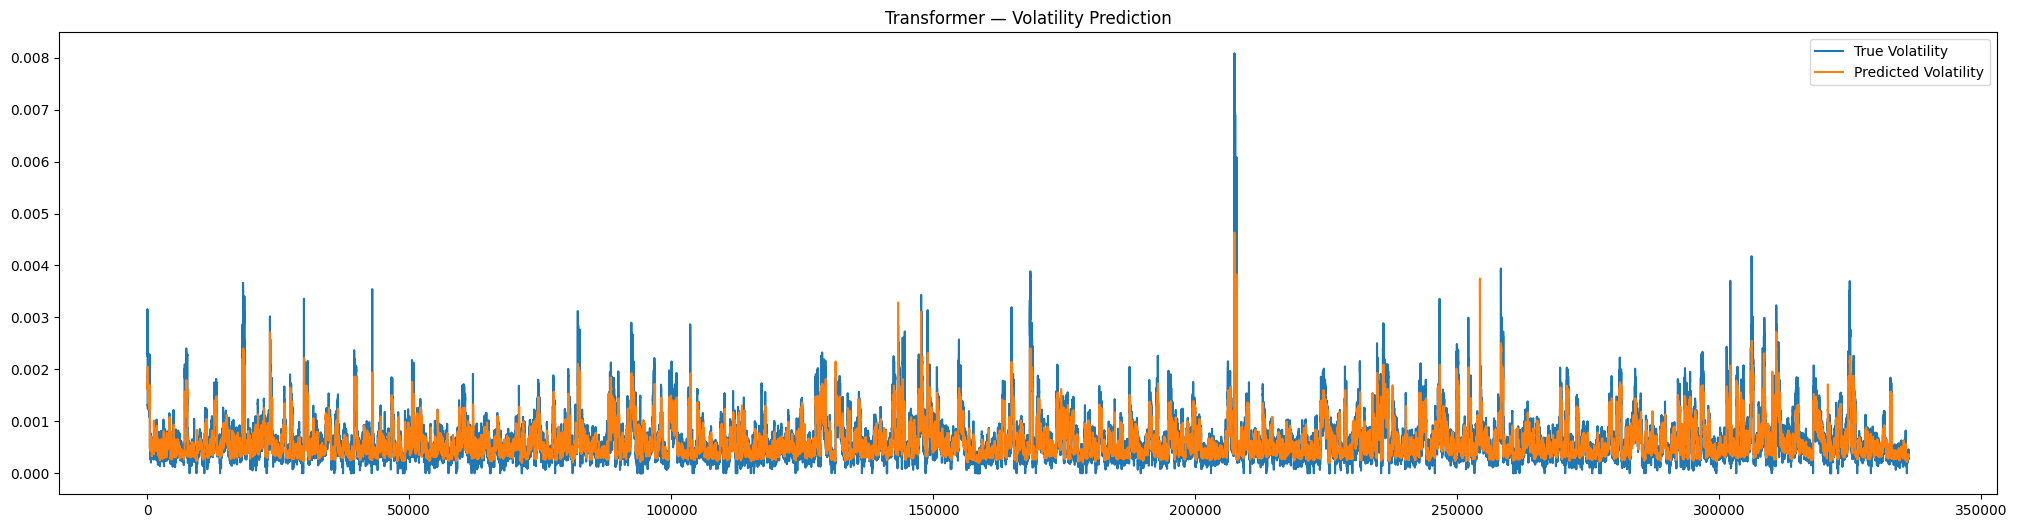

In [158]:
plt.figure(figsize=(25, 6))
plt.plot(actuals, label="True Volatility")
plt.plot(predictions, label="Predicted Volatility")
plt.legend()
plt.title("Transformer — Volatility Prediction")
plt.show()

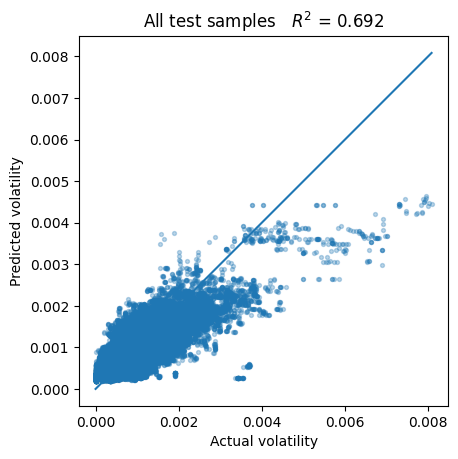

In [159]:
plt.figure()
plt.scatter(actuals, predictions, alpha=0.3, s=8)
lim = [min(actuals.min(), predictions.min()),
       max(actuals.max(), predictions.max())]
plt.plot(lim, lim)                     
plt.title(f"All test samples   $R^2$ = {r2_score(actuals, predictions):.3f}")
plt.xlabel("Actual volatility")
plt.ylabel("Predicted volatility")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

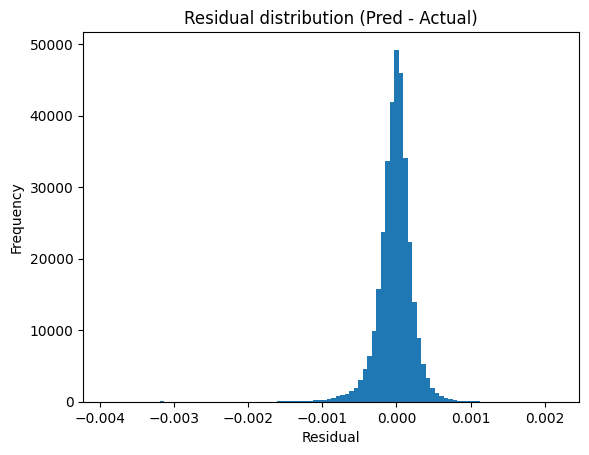

In [160]:
residuals = predictions - actuals
plt.figure()
plt.hist(residuals, bins=100)
plt.title("Residual distribution (Pred - Actual)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [161]:
model_name_value = "Transformer" 
pred_related_stock_ids = []
pred_related_time_ids = []
original_test_df_for_ids = df[df["time_id"].isin(test_sessions)].copy()

for current_time_id_value in test_sessions:
    session_df_from_original = original_test_df_for_ids[original_test_df_for_ids["time_id"] == current_time_id_value]
    num_y_samples_in_session = len(session_df_from_original) - SEQ_LEN
    if num_y_samples_in_session > 0:
        stock_ids_for_session_targets = session_df_from_original['stock_id'].iloc[SEQ_LEN:].values.tolist()
        
        pred_related_stock_ids.extend(stock_ids_for_session_targets)
        pred_related_time_ids.extend([current_time_id_value] * num_y_samples_in_session)

if len(pred_related_stock_ids) != len(predictions):
    print(f"Warning: Length mismatch between reconstructed stock_ids ({len(pred_related_stock_ids)}) and predictions ({len(predictions)}).")

if len(pred_related_time_ids) != len(predictions):
    print(f"Warning: Length mismatch between reconstructed time_ids ({len(pred_related_time_ids)}) and predictions ({len(predictions)}).")

results_df = pd.DataFrame({
    'stock_id': pred_related_stock_ids,
    'time_id': pred_related_time_ids,
    'model_name': model_name_value,
    'mse': mse,  
    'qlike': ql, 
    'r^2': r2,  
    'pred_vol': predictions,
    'true_vol': actuals
})

output_csv_filename = f"{pred_related_stock_ids[0]}.csv"
results_df.to_csv(output_csv_filename, index=False)

print(f"Model findings saved to {output_csv_filename}")

Model findings saved to 120.csv
